In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the IMDb dataset
df = pd.read_csv('IMDB Dataset.csv')

# Preprocessing: Convert labels to binary (0 for 'negative', 1 for 'positive')
df['binary_sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Split the data into training, validation, and testing sets
X = df['review'].values
y = df['binary_sentiment'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize and encode the text data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt', max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt', max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt', max_length=128)

# Create DataLoader objects
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(y_val))
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


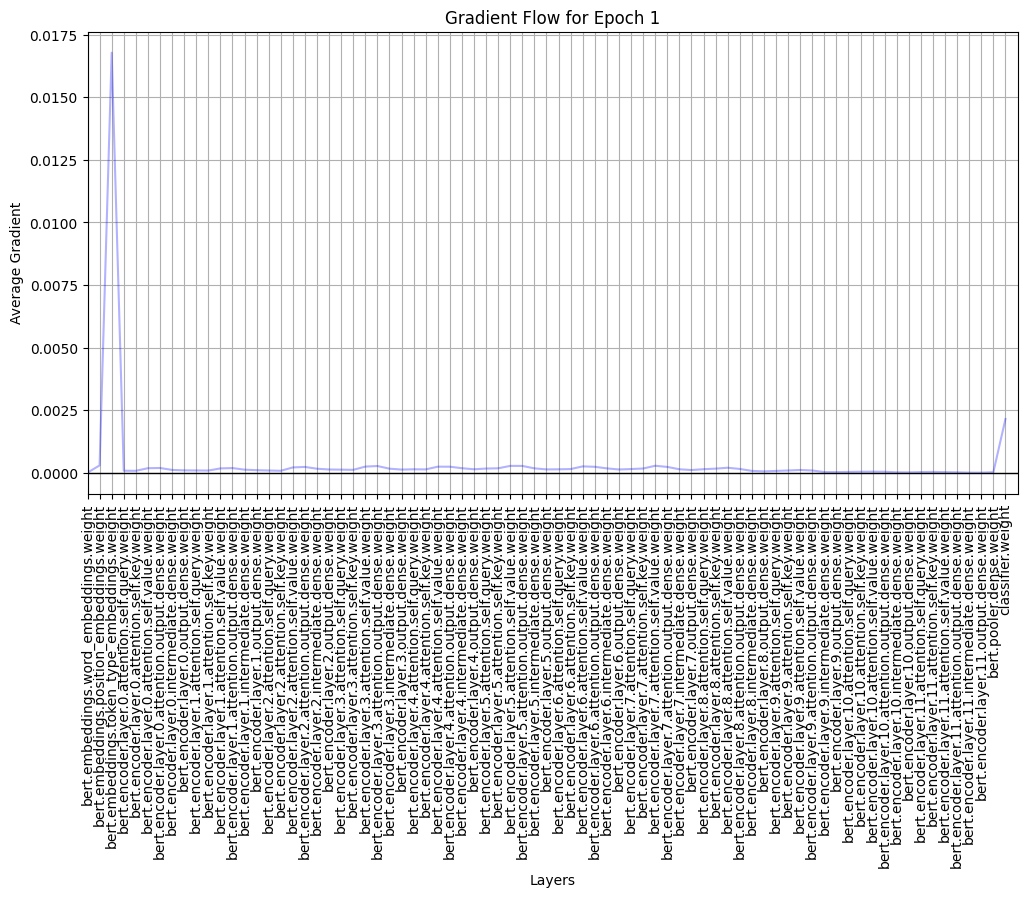

Epoch 1/10 - Validation Loss: 0.6071, Validation Accuracy: 0.8998


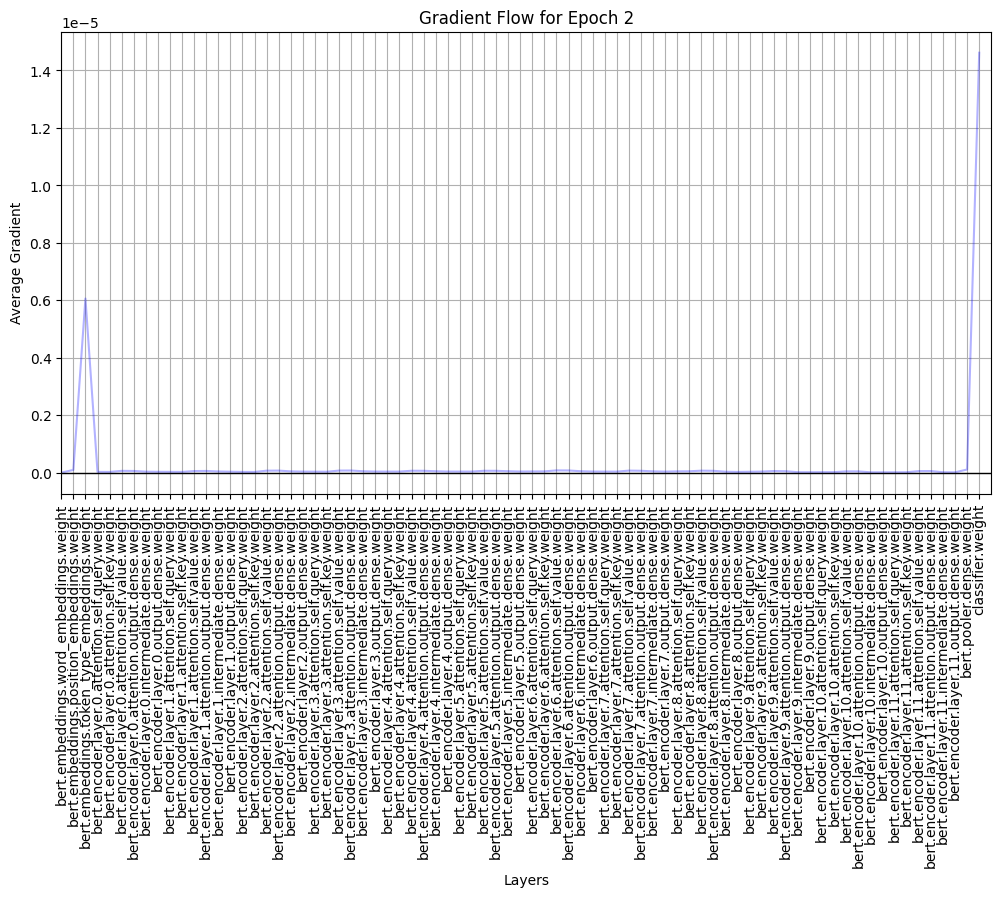

Epoch 2/10 - Validation Loss: 0.6288, Validation Accuracy: 0.8976


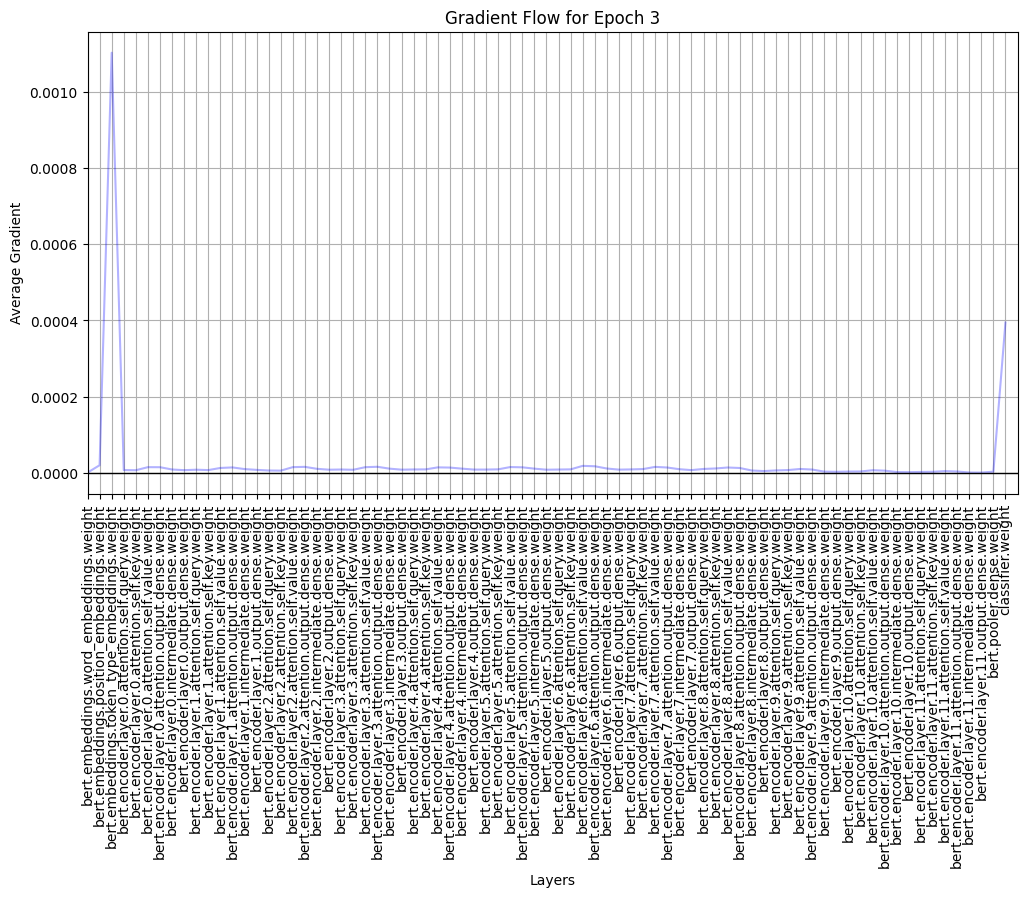

Epoch 3/10 - Validation Loss: 0.5928, Validation Accuracy: 0.8970


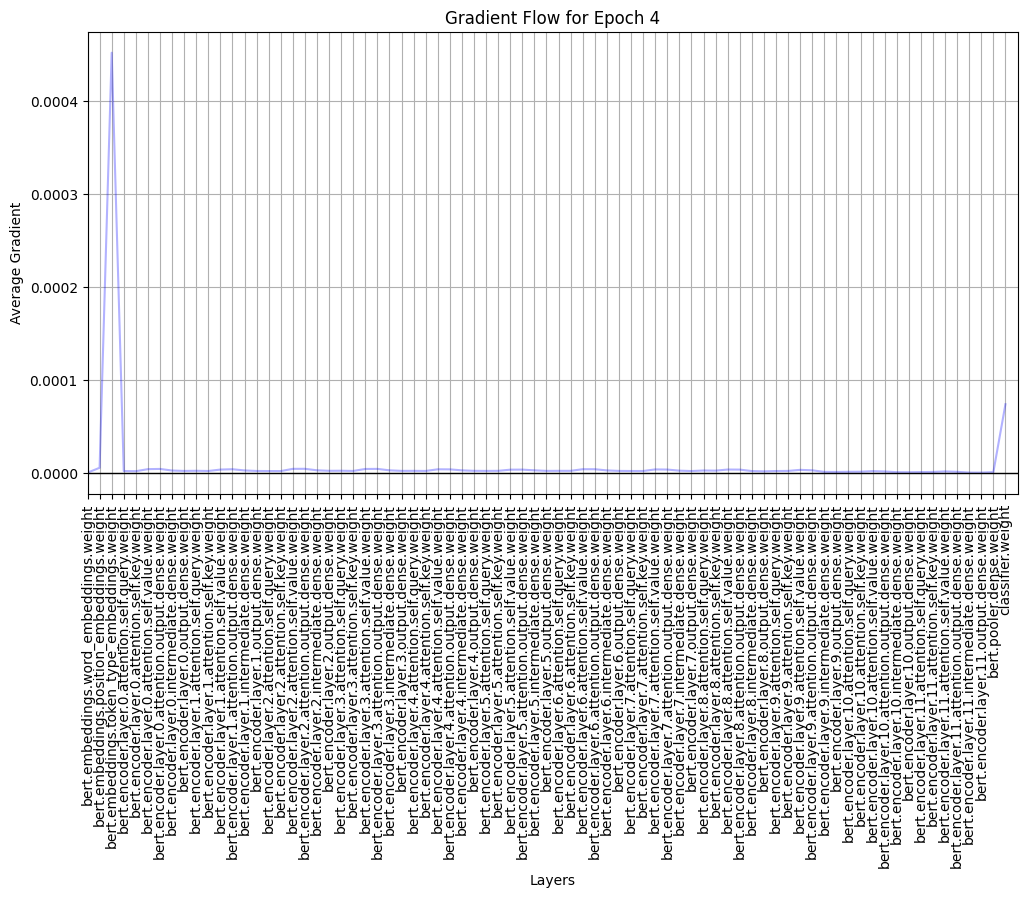

Epoch 4/10 - Validation Loss: 0.5643, Validation Accuracy: 0.8986


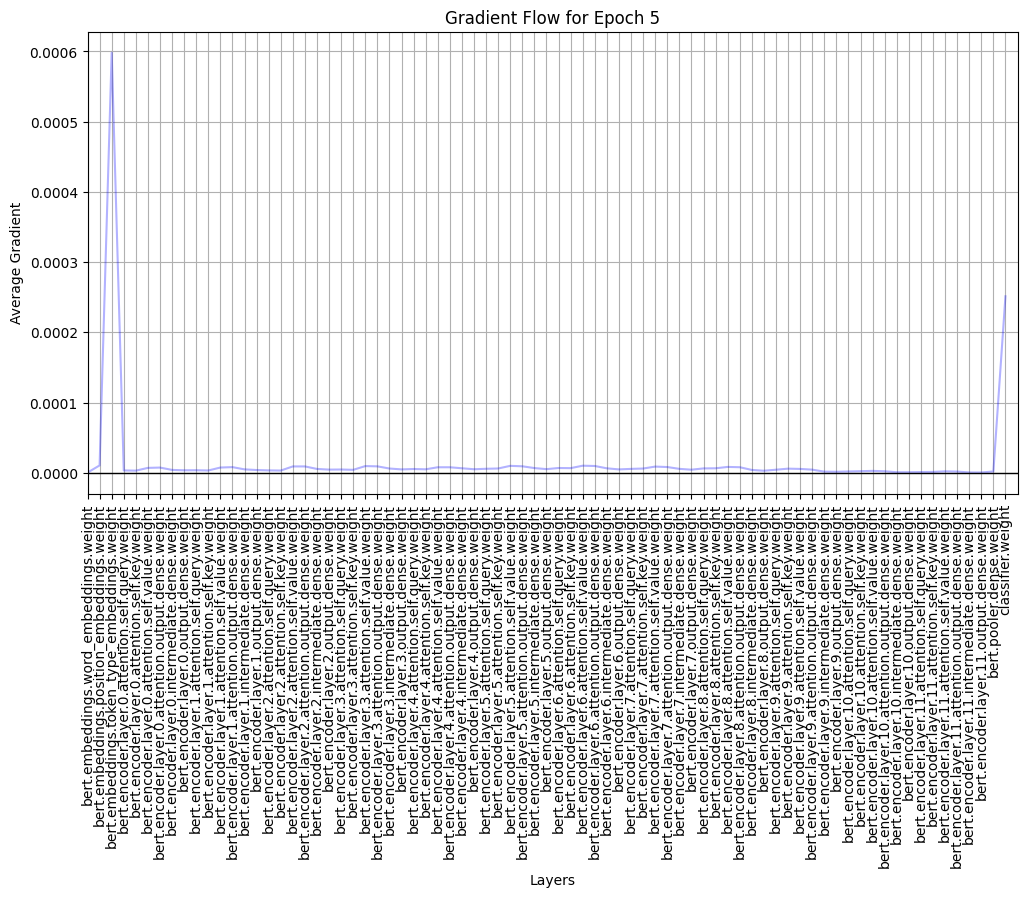

Epoch 5/10 - Validation Loss: 0.5949, Validation Accuracy: 0.8996


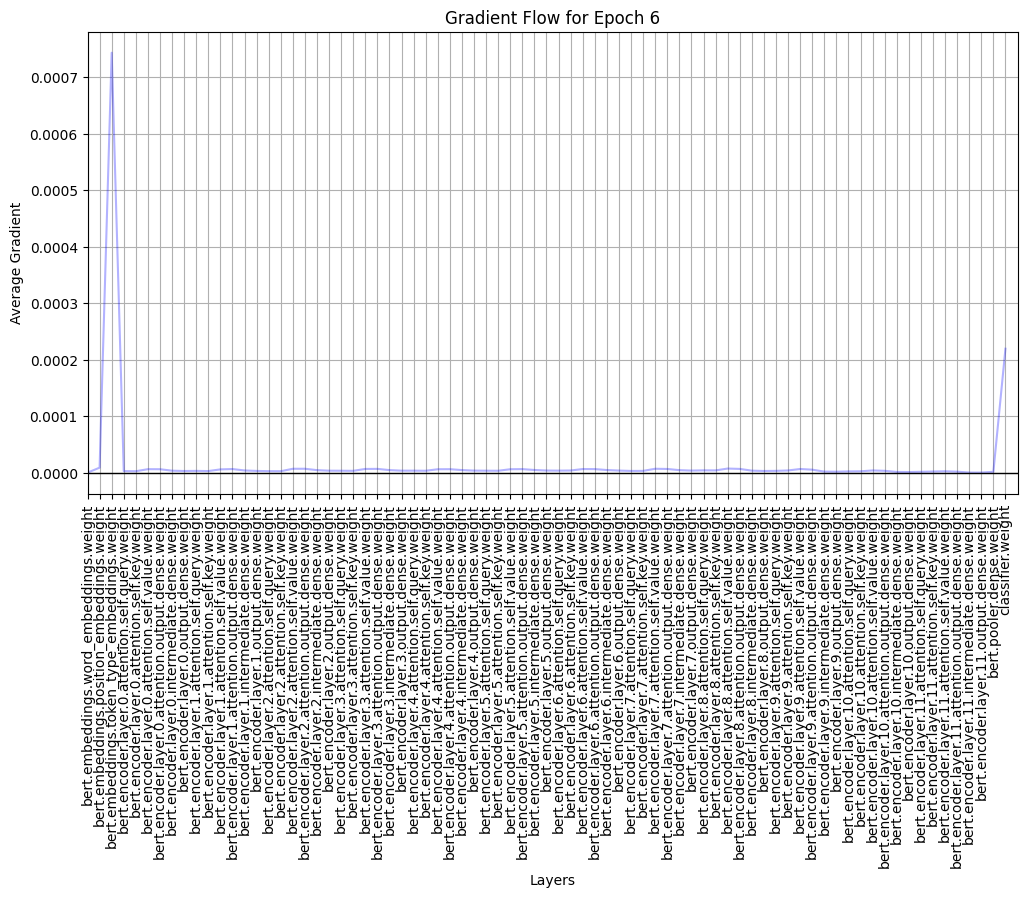

Epoch 6/10 - Validation Loss: 0.5869, Validation Accuracy: 0.8994


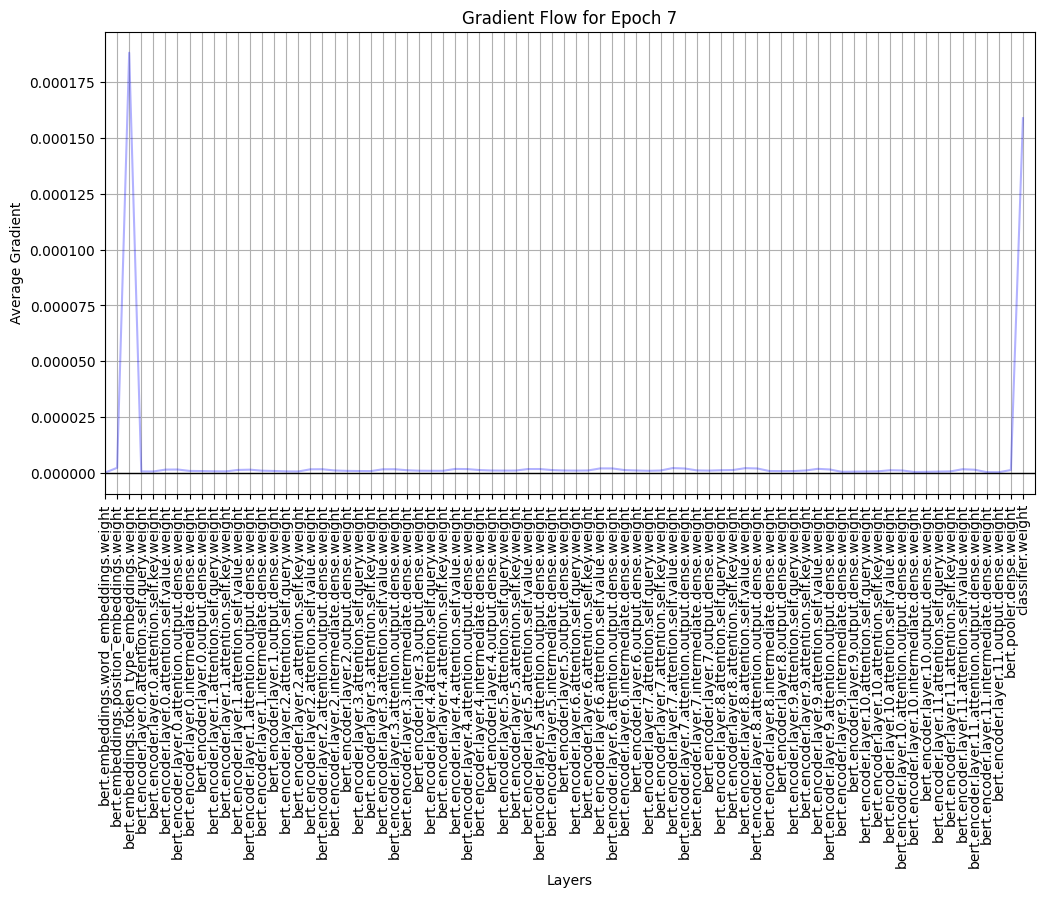

Epoch 7/10 - Validation Loss: 0.4761, Validation Accuracy: 0.8984


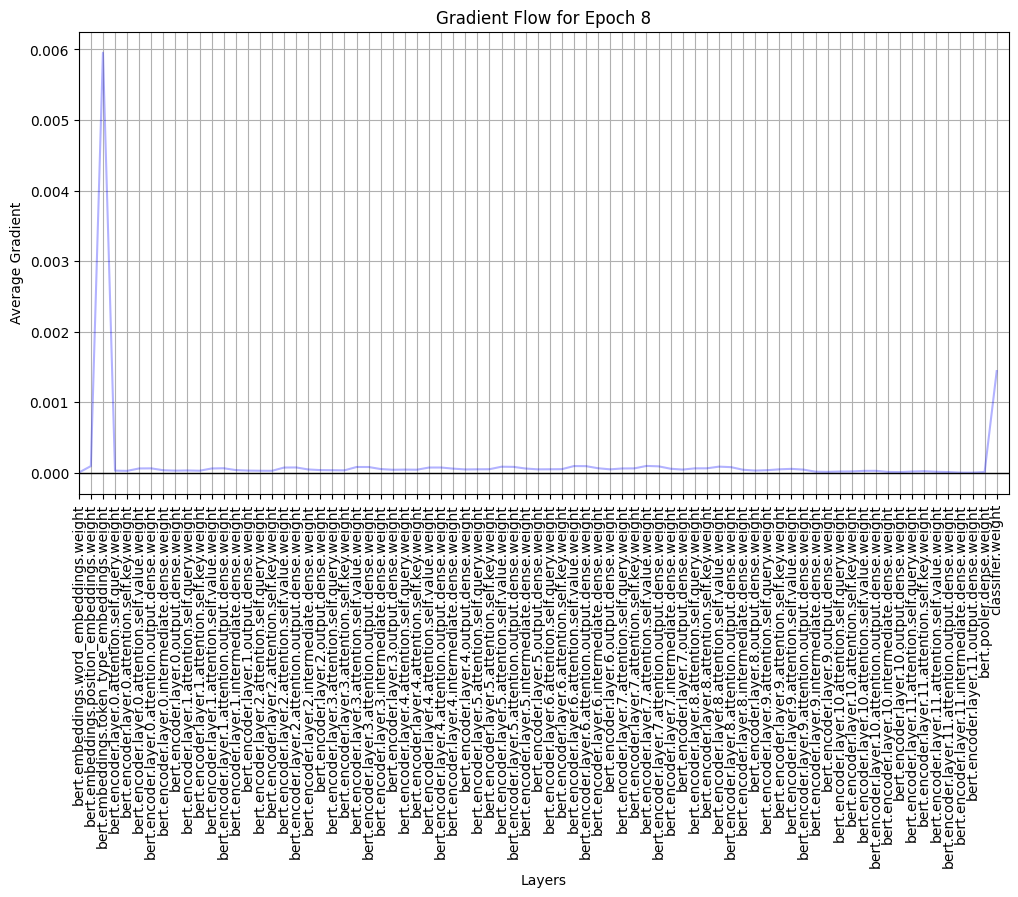

Epoch 8/10 - Validation Loss: 0.6440, Validation Accuracy: 0.8950


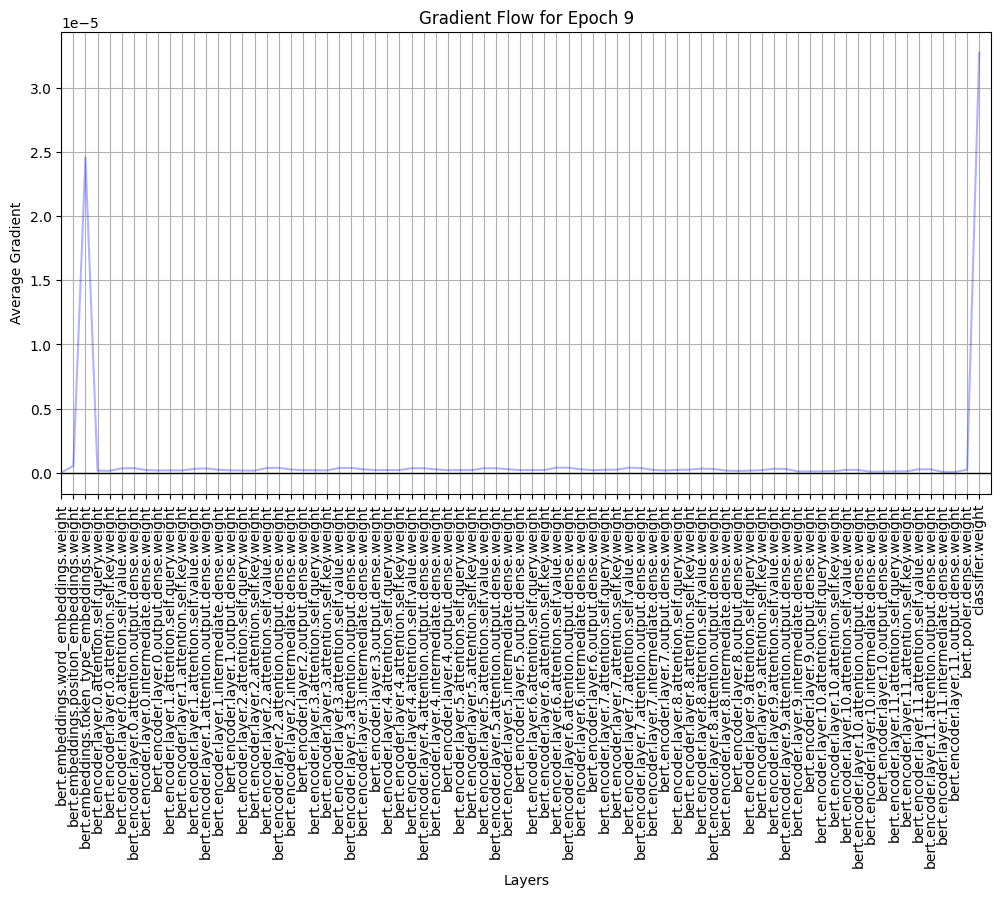

Epoch 9/10 - Validation Loss: 0.5463, Validation Accuracy: 0.8944


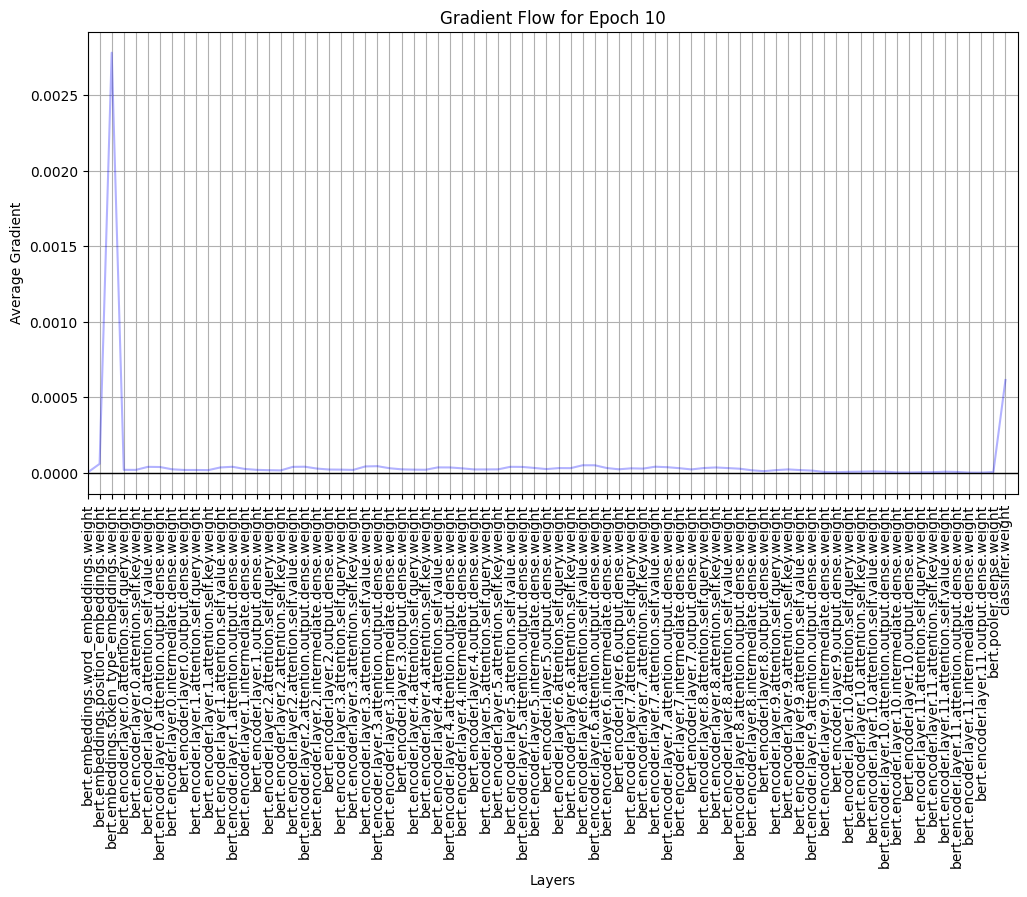

Epoch 10/10 - Validation Loss: 0.5435, Validation Accuracy: 0.9000

Test Accuracy: 0.8978


In [ ]:
# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


def plot_grad_flow(named_parameters, epoch):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
      if (p.requires_grad) and ("bias" not in n) and ("LayerNorm" not in n):
        layers.append(n)
        ave_grads.append(p.grad.abs().mean().cpu().numpy())


    plt.figure(figsize=(12, 6))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads), linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title(f"Gradient Flow for Epoch {epoch+1}")
    plt.grid(True)
    plt.show()



# Training and evaluation loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 10  # You can adjust the number of epochs
for epoch in range(epochs):
    # Training Phase
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training', leave=False)
    for batch in progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': loss.item()})

    plot_grad_flow(model.named_parameters(), epoch)  # Plot gradient flow after each epoch

    # Validation Phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_true_labels = []
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation', leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)

            val_loss += loss.item()
            val_predictions.extend(predicted_labels.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Test Accuracy
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)

        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nTest Accuracy: {accuracy}")


